In [2]:
import itertools
import numpy as np
import numpy.random as npr
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import colors
from matplotlib import gridspec
import matplotlib

import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D  

import scipy.io
from scipy.io import loadmat
from scipy.io import savemat
from scipy import stats
from scipy.special import softmax
from sklearn.metrics import log_loss
import pickle
import copy

%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.family':'Arial'})

In [22]:
subjectNames = ['sam','tabitha','chloe','blanche','b01','b02','b03','b04','b05','b06','b07','b08','b09','b10']

numSubjects = len(subjectNames)

stateNames = ['Persist','Preferred','Random','Avoid']
historyNames = ['(0,0)','(1,0)','(0,1)','(1,1)']

speciesList = np.array([0,0,0,0,1,1,1,1,1,2,2,2,2,2])

speciesColor = ['#fb8072','#8dd3c7','#74add1']
speciesDColor = ['#6a0e03','#1d4c44','#183649']
speciesNames = ['monkey','human','human2']


def getPM(N):
    if N == 1:
        return 1
    elif N > 1:
        x = np.zeros([N])
        x[0] = 1
        for i in np.arange(1,N):
            x[i] = -1 * x[i-1]
        return x

######################################

analysis = []
data = []
data0 = []


for i in range(numSubjects):
    with open('analysis/'+subjectNames[i]+'.pickle', 'rb') as f:
        [A] = pickle.load(f)
    analysis.append(A)
    with open('data/'+subjectNames[i]+'.pickle', 'rb') as f:
        [D] = pickle.load(f)
    data.append(D)
    data0.append(D)
    
# subjectNames = ['nhp_01','nhp_02','nhp_03','nhp_04','b_01','b_02','b_03','b_04','b_05']
subjectNames = ['1','2','3','4','1','2','3','4','5','1','2','3','4','5']


categoryNames = ['block length',
                 'Perseveration',
                 'Random search',
                 'Rule random, \n Exploration',
                 'Rule favored, \n Exploration',
                 'Rule preferred, \n No exploration',
                 'Rule persist, \n No exploration']

In [23]:
proportionExplore = np.zeros([numSubjects])
uniqueExplore = []
simultaneousExplore = []
ellNonRuleExplore = []

for i in range(numSubjects):
    proportionExplore[i] = analysis[i]['categoryAnalysis']['exploreTrialsProportion']
    uniqueExplore.append(analysis[i]['categoryAnalysis']['numNonRuleExplore'])

    X = np.concatenate(analysis[i]['categoryAnalysis']['simultaneousExplore'])
    X = X[X>0]
    simultaneousExplore.append(X)

    X = analysis[i]['categoryAnalysis']['ellAllExplore']
    Y = []
    for j in range(len(X)):
        Y.append(np.concatenate(X[j]))
    ellNonRuleExplore.append(np.concatenate(Y))

# speciesColor = [np.array([251/255, 128/255, 114/255]), np.array([141/255, 211/255, 199/255])]

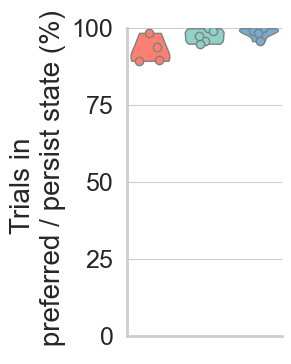

In [24]:
fig, ax = plt.subplots(figsize=(2,4))

vpWidth = 0.5

for spInd in range(3):
    idx = np.where(np.array(speciesList) == spInd)[0]
    data = proportionExplore[idx]*100.0
    vp = ax.violinplot(data,[spInd*0.7],showextrema=False,widths=vpWidth)
    
    x = npr.rand(idx.shape[0]) * (vpWidth) * (0.3)
    pm = getPM(idx.shape[0])
    x = np.multiply(x,pm) + spInd*0.7
    
    ax.scatter(x,data,color=speciesColor[spInd],edgecolors='gray')

    for pc in vp['bodies']:
        pc.set_facecolor(speciesColor[spInd])
        pc.set_edgecolor('gray')
        pc.set_alpha(1)
        
    ax.scatter(i*0.7,np.mean(data),color='white',s=50,edgecolors='gray')

ax.set_ylim([0,100])
ax.set_xlim([-0.3,1.7])
ax.set_xticks([])
ax.set_yticks([0,25,50,75,100])
# ax.set_xticklabels(['Monkeys','Humans'],fontsize=18)
# ax.set_xticklabels(speciesNames,fontsize=20)
ax.set_ylabel('Trials in \n preferred / persist state (%)',fontsize=20)
# ax.set_ylabel('proportion of trials with at least \n one feature in preferred/persist state',fontsize=15)
ax.tick_params(axis='x',labelsize= 18,direction='out',length=6,width=2)
ax.tick_params(axis='y',labelsize= 18,direction='out',length=6,width=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

# increase tick width
# ax.tick_params(width=2,length=5)

# plt.savefig('trialsInExp.eps', format='eps')

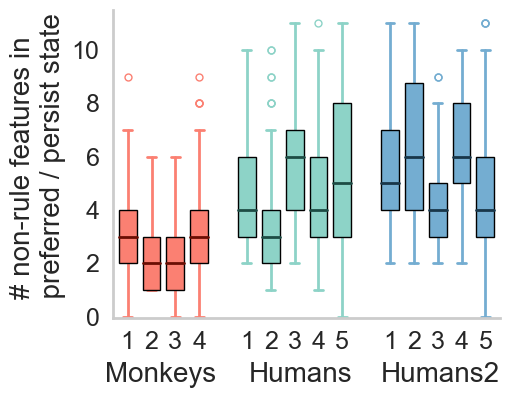

In [33]:
fig, ax = plt.subplots(figsize=(5,4))

xPos = []

pos = -0.8*2
for spInd in range(3):
    idx = np.where(np.array(speciesList) == spInd)[0]

    prop1 = dict(color=speciesColor[spInd],linewidth=2)
    prop2 = dict(color=speciesDColor[spInd],linewidth=2)
    prop3 = dict(markeredgecolor=speciesColor[spInd],marker='.',markersize=10,linewidth=4)

    pos += 0.8
    for i in idx:

        pos += 0.8

        xPos.append(pos)

        bp = ax.boxplot(uniqueExplore[i],positions=[pos],widths=0.6,patch_artist=True,medianprops=prop2,whiskerprops=prop1,capprops=prop1,flierprops=prop3,zorder=0)

        bp['boxes'][0].set_facecolor(speciesColor[spInd])

ax.set_xlim([xPos[0]-0.5,xPos[-1]+0.5])
ax.set_ylim([-0.05,11.5])
ax.set_xticks(xPos)
ax.set_xticklabels(subjectNames,fontsize=10) #,rotation=30

fig.text(0.22, -0.05, 'Monkeys', ha='center', size=20)
fig.text(0.5, -0.05, 'Humans', ha='center', size=20)
fig.text(0.78, -0.05, 'Humans2', ha='center', size=20)

# ax.set_ylabel('# of non-rule features in \n  preferred/persist state \n per block',fontsize=15)
ax.set_ylabel('# non-rule features in \n  preferred / persist state',fontsize=20)


ax.tick_params(axis='both',direction='out',width=2, length=6)
ax.tick_params(axis='x',labelsize=18)
ax.tick_params(axis='y',labelsize=18)
# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_axisbelow(True)
ax.grid(which='major', axis='both')

# plt.savefig('featExpPerBlock.eps', format='eps')
plt.show()



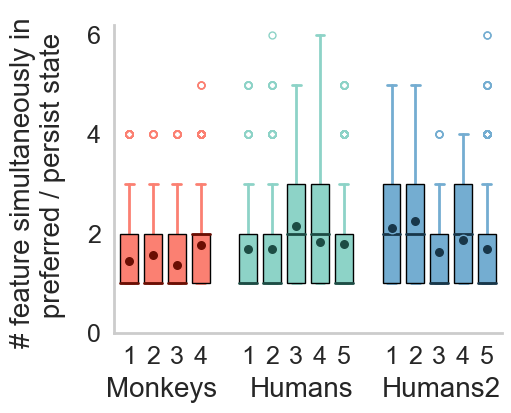

In [34]:
fig, ax = plt.subplots(figsize=(5,4))

xPos = []


pos = -0.8*2
for spInd in range(3):
    idx = np.where(np.array(speciesList) == spInd)[0]

    prop1 = dict(color=speciesColor[spInd],linewidth=2)
    prop2 = dict(color=speciesDColor[spInd],linewidth=2)
    prop3 = dict(markeredgecolor=speciesColor[spInd],marker='.',markersize=10,linewidth=4)
    prop4 = dict(markerfacecolor=speciesDColor[spInd],
                 markeredgecolor=speciesColor[spInd],marker='.',markersize=15)

    pos += 0.8
    for i in idx:

        pos += 0.8

        xPos.append(pos)
        data = simultaneousExplore[i] #np.concatenate(simultaneousExplore[i])
        bp = ax.boxplot(data,positions=[pos],widths=0.6,patch_artist=True,medianprops=prop2,whiskerprops=prop1,
                        capprops=prop1,flierprops=prop3,zorder=0,showmeans=True,meanprops=prop4)

        bp['boxes'][0].set_facecolor(speciesColor[speciesList[i]])

ax.set_xlim([xPos[0]-0.5,xPos[-1]+0.5])
ax.set_ylim([0,6.2])
ax.set_xticks(xPos)
ax.set_xticklabels(subjectNames,fontsize=10) #rotation=30,

fig.text(0.22, -0.05, 'Monkeys', ha='center', size=20)
fig.text(0.5, -0.05, 'Humans', ha='center', size=20)
fig.text(0.78, -0.05, 'Humans2', ha='center', size=20)

# ax.set_ylabel('# of simultaneously explore features \n per trial',fontsize=15)
ax.set_ylabel('# feature simultaneously in \n preferred / persist state',fontsize=20,labelpad=15)


ax.tick_params(axis='both',direction='out',width=2, length=6)
ax.tick_params(axis='x',labelsize=18)
ax.tick_params(axis='y',labelsize=18)
# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_axisbelow(True)
ax.grid(which='major', axis='both')

# plt.savefig('featExpSimult.eps', format='eps')
plt.show()



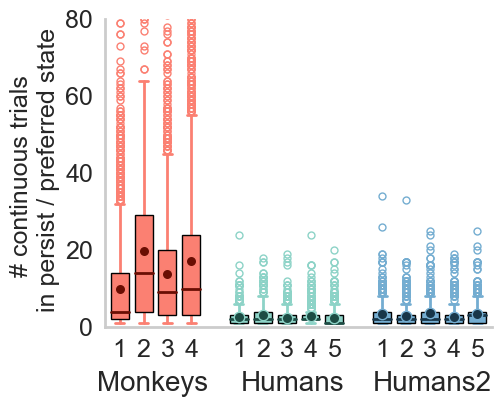

In [37]:
fig, ax = plt.subplots(figsize=(5,4))

xPos = []



pos = -0.8*2
for spInd in range(3):
    idx = np.where(np.array(speciesList) == spInd)[0]

    prop1 = dict(color=speciesColor[spInd],linewidth=2)
    prop2 = dict(color=speciesDColor[spInd],linewidth=2)
    prop3 = dict(markeredgecolor=speciesColor[spInd],marker='.',markersize=10,linewidth=4)
    prop4 = dict(markerfacecolor=speciesDColor[spInd],
                 markeredgecolor=speciesColor[spInd],marker='.',markersize=15)

    pos += 0.8
    for i in idx:

        pos += 0.8


        xPos.append(pos)
        data = ellNonRuleExplore[i]
        bp = ax.boxplot(data,positions=[pos],widths=0.6,patch_artist=True,medianprops=prop2,whiskerprops=prop1,
                        capprops=prop1,flierprops=prop3,zorder=0,showmeans=True,meanprops=prop4)

        bp['boxes'][0].set_facecolor(speciesColor[speciesList[i]])

ax.set_xlim([xPos[0]-0.5,xPos[-1]+0.5])
ax.set_ylim([0,80])
ax.set_xticks(xPos)
ax.set_xticklabels(subjectNames,fontsize=10)# ,rotation=30

fig.text(0.22, -0.05, 'Monkeys', ha='center', size=20)
fig.text(0.5, -0.05, 'Humans', ha='center', size=20)
fig.text(0.78, -0.05, 'Humans2', ha='center', size=20)

# ax.set_ylabel('# continuous trials with non-rule \n feature in persist / preferred state',fontsize=18)
ax.set_ylabel('# continuous trials \n in persist / preferred state',fontsize=18)


ax.tick_params(axis='both',direction='out',width=2,length=6)
ax.tick_params(axis='x',length=5,labelsize=18)
ax.tick_params(axis='y',length=5,labelsize=18)
# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_axisbelow(True)
ax.grid(which='major', axis='both')


# plt.savefig('contTrialsExp.eps', format='eps')
plt.show()



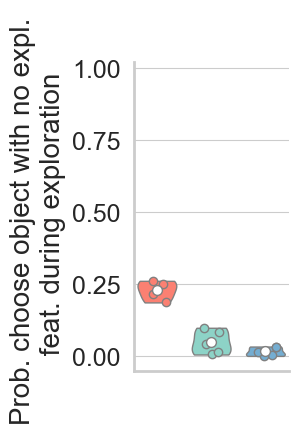

In [40]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(2,4), sharey=True)

vpWidth = 0.5

B = np.zeros((numSubjects))
for i in range(numSubjects):
    B[i] = 1.0-analysis[i]['categoryAnalysis']['randomnessDurExp'] #[8]

for i in np.unique(speciesList):
    idx = np.where(np.array(speciesList) == i)[0]
    data = B[idx]
    data = np.delete(data,np.nonzero(np.isnan(data))[0], axis=0)
    vp = ax.violinplot(data,[i*0.7],showextrema=False,widths=vpWidth)

    x = npr.rand(data.shape[0]) * (vpWidth) * (0.3)
    pm = getPM(data.shape[0])
    x = np.multiply(x,pm)+i*0.7#-0.1#i-0.1 #np.multiply(x,pm) + i

    ax.scatter(x,data,color=speciesColor[i],edgecolors='gray')

    for pc in vp['bodies']:
        pc.set_facecolor(speciesColor[i])
        pc.set_edgecolor('gray')
        pc.set_alpha(1)

    ax.scatter(i*0.7,np.mean(data),color='white',s=50,edgecolors='gray')

ax.set_ylim([-0.05,1.02])
ax.set_xlim([-0.3,1.7])
ax.set_xticks([])
#     ax[j].set_xticklabels(['Monkeys','Humans'],fontsize=18)

ax.set_yticks([0,0.25,0.5,0.75,1])

ax.set_ylabel('Prob. choose object with no expl. \n feat. during exploration',fontsize=20)

ax.tick_params(axis='both',labelsize= 18,direction='out',width=2, length=6)
# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.subplots_adjust(wspace=0.3, 
#                     hspace=0.0)  
# plt.savefig('randomChDurExp.eps', format='eps')
plt.show()